
## Project 7 - Neural Networks
Recognizing multi-digit numbers in photographs captured at street level is an important component of modern-day map making. A classic example of a corpus of such street level photographs is Google’s Street View imagery comprised of hundreds of millions of geo-located 360 degree panoramic images. The ability to automatically transcribe an address number from a geo-located patch of pixels and associate the transcribed number with a known street address helps pinpoint, with a high degree of accuracy, the location of the building it represents. 

More broadly, recognizing numbers in photographs is a problem of interest to the optical character recognition community. While OCR on constrained domains like document processing is well studied, arbitrary multi-character text recognition in photographs is still highly challenging. This difficulty arises due to the wide variability in the visual appearance of text in the wild on account of a large range of fonts, colors, styles, orientations, and character arrangements. The recognition problem is further complicated by environmental factors such as lighting, shadows, specularities, and occlusions as well as by image acquisition factors such as resolution, motion, and focus blurs.

In this project we will use dataset with images centred around a single digit (many of the images do contain some distractors at the sides). Although we are taking a sample of the data which is simpler, it is more complex than MNIST because of the distractors. 

**The Street View House Numbers (SVHN) Dataset**

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data formatting but comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

Link to Dataset: https://www.kaggle.com/datasets/sasha18/street-view-house-nos-h5-file



**Acknowledgement for the datasets**

Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, Andrew Y. Ng Reading Digits in Natural Images with Unsupervised Feature Learning NIPS Workshop on Deep Learning and Unsupervised Feature Learning 2011. PDF http://ufldl.stanford.edu/housenumbers as the URL for this site when necessary.

**Objective of the project** is to learn how to implement a simple image classification pipeline based on a deep neural network.

* Understand the basic Image Classification pipeline and the data-driven approach (train/predict stages)
* Data fetching and understand the train/val/test splits
* Implement and apply a deep neural network classifier including (feed forward neural network, RELU, activations)
* Understand and be able to implement (vectorized) backpropagation (cost stochastic gradient descent, cross entropy loss, cost functions)
* Implement batch normalization for training the neural network
* Print the classification accuracy metrics

<a id='import'></a>
### Import Packages

In [2]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, h5py
import matplotlib.style as style; style.use('fivethirtyeight')
%matplotlib inline

# Metrics and preprocessing
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# TF and Keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

# Checking if GPU is found
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.compat.v1.reset_default_graph()
tf.random.set_seed(42)

Found GPU at: /device:GPU:0


<a id='load'></a>
### Load train, val and test datasets from h5py file

In [3]:
# Read the h5 file
h5_SVH = h5py.File('SVHN_single_grey1.h5', 'r')

# Load the training, validation and test sets
X_train = h5_SVH['X_train'][:]
y_train_o = h5_SVH['y_train'][:]
X_val = h5_SVH['X_val'][:]
y_val_o = h5_SVH['y_val'][:]
X_test = h5_SVH['X_test'][:]
y_test_o = h5_SVH['y_test'][:]

# Close this file

h5_SVH.close()

print('Training set', X_train.shape, y_train_o.shape)
print('Validation set', X_val.shape, y_val_o.shape)
print('Test set', X_test.shape, y_test_o.shape)

print('\n')
print('Unique labels in y_train:', np.unique(y_train_o))
print('Unique labels in y_val:', np.unique(y_val_o))
print('Unique labels in y_test:', np.unique(y_test_o))

Training set (42000, 32, 32) (42000,)
Validation set (60000, 32, 32) (60000,)
Test set (18000, 32, 32) (18000,)


Unique labels in y_train: [0 1 2 3 4 5 6 7 8 9]
Unique labels in y_val: [0 1 2 3 4 5 6 7 8 9]
Unique labels in y_test: [0 1 2 3 4 5 6 7 8 9]


<a id='o1'></a>
#### Observation 1 - Sets Shape
* Length of training sets: 42k, validation sets: 60k, test sets: 18k
* Size of the images: 32*32
* Number of class: 10

<a id='visualize'></a>
### Visualizing first 10 images

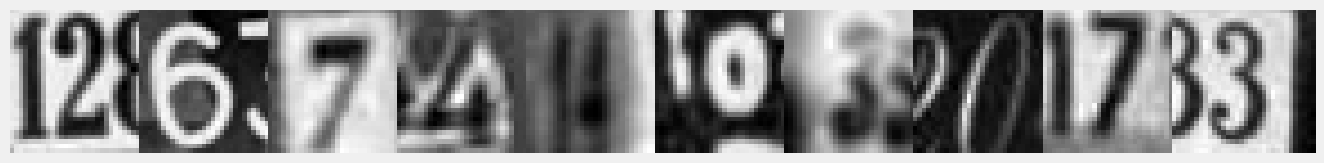

Label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [4]:
# Visualizing first 10 images in the dataset and their labels
plt.figure(figsize = (15, 4.5))
for i in range(10):  
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape((32, 32)),cmap = plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace = -0.1, hspace = -0.1)
plt.show()

print('Label for each of the above image: %s' % (y_train_o[0 : 10]))

Checking first image and label in training set
--------------------------------------------------------------------------------


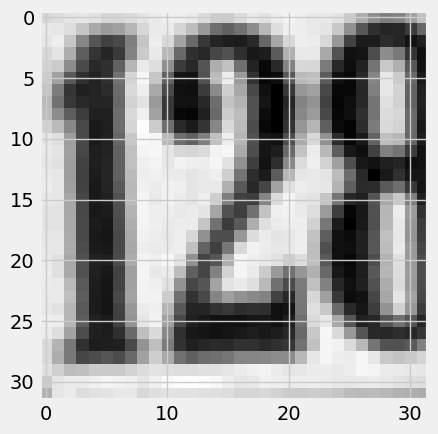

Label: 2


In [5]:
print('Checking first image and label in training set'); print('--'*40)
plt.imshow(X_train[0], cmap = plt.cm.binary)    
plt.show()
print('Label:', y_train_o[0])

Checking first image and label in validation set
--------------------------------------------------------------------------------


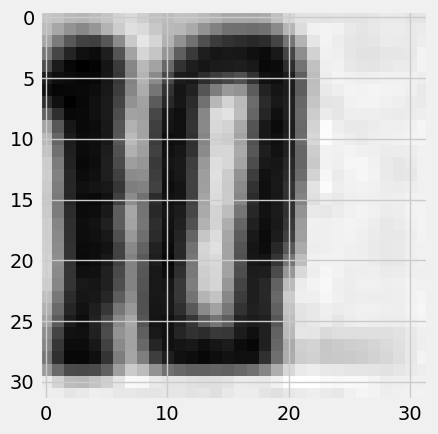

Label: 0


In [6]:
print('Checking first image and label in validation set'); print('--'*40)
plt.imshow(X_val[0], cmap = plt.cm.binary)    
plt.show()
print('Label:', y_val_o[0])

Checking first image and label in test set
--------------------------------------------------------------------------------


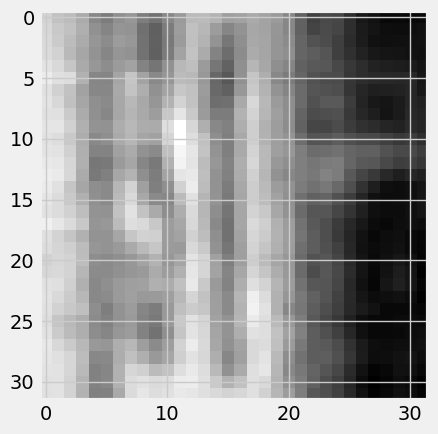

Label: 1


In [7]:
print('Checking first image and label in test set'); print('--'*40)
plt.imshow(X_test[0], cmap = plt.cm.binary)    
plt.show()
print('Label:', y_test_o[0])

<a id='flatten'></a>
### Flatten and normalize the images for Keras

In [8]:
print('Reshaping X data: (n, 32, 32) => (n, 1024)'); print('--'*40)
X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

print('Making sure that the values are float so that we can get decimal points after division'); print('--'*40)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print('Normalizing the RGB codes by dividing it to the max RGB value'); print('--'*40)
X_train /= 255
X_val /= 255
X_test /= 255

print('Converting y data into categorical (one-hot encoding)'); print('--'*40)
y_train = to_categorical(y_train_o)
y_val = to_categorical(y_val_o)
y_test = to_categorical(y_test_o)

Reshaping X data: (n, 32, 32) => (n, 1024)
--------------------------------------------------------------------------------
Making sure that the values are float so that we can get decimal points after division
--------------------------------------------------------------------------------
Normalizing the RGB codes by dividing it to the max RGB value
--------------------------------------------------------------------------------
Converting y data into categorical (one-hot encoding)
--------------------------------------------------------------------------------


In [9]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

print('\n')
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

print('\n')
print('Number of images in X_train', X_train.shape[0])
print('Number of images in X_val', X_val.shape[0])
print('Number of images in X_test', X_test.shape[0])

X_train shape: (42000, 1024)
X_val shape: (60000, 1024)
X_test shape: (18000, 1024)


y_train shape: (42000, 10)
y_val shape: (60000, 10)
y_test shape: (18000, 10)


Number of images in X_train 42000
Number of images in X_val 60000
Number of images in X_test 18000


<a id='Baby'></a>
### Modelling - Baby sitting the learning process

#### Fully connected linear layer

In [10]:
class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None        

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

#### ReLU

In [11]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

#### Softmax function

In [12]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

#### Cross entropy loss

In [13]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

#### NN class that enables the forward prop and backward propagation of the entire network

In [14]:
class NN():
    def __init__(self, lossfunc = CrossEntropy(), mode = 'train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

#### Update function SGD with momentum

In [15]:
def update(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = (mu * v[i]) - (learning_rate * g[i])
            p[i] += v[i]

#### Get minibatches

In [16]:
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
        
    return minibatches

#### The training loop

In [17]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu = 0.9, X_val = None, y_val = None, Lambda = 0, verb = True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)
    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = []
        y_val_pred = []
        y_train1 = []
        y_vall = []
        for ii in range(0, m_train, minibatch_size):
            X_tr = X_train[ii:ii + minibatch_size, : ]
            y_tr = y_train[ii:ii + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for ii in range(0, m_val, minibatch_size):
            X_va = X_val[ii:ii + minibatch_size, : ]
            y_va = y_val[ii:ii + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)
        
        ## weights
        w = np.array(net.params[0][0])
        
        ## adding regularization to cost
        mean_train_loss = (sum(loss_batch) / float(len(loss_batch)))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        if verb:
            if i%50==0:
                print("Epoch {3}/{4}: Loss = {0} | Training Accuracy = {1}".format(mean_train_loss, train_acc, val_acc, i, epoch))
    return net, val_acc

#### Checking the accuracy of the model

In [18]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

#### Invoking all that we have created until now

In [19]:
# Invoking the model
## input size
input_dim = X_train.shape[1]

def train_and_test_loop(iterations, lr, Lambda, verb = True):
    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes1 = 10
    output_nodes = 10

    ## define neural net
    nn = NN()
    nn.add_layer(Linear(input_dim, hidden_nodes1))

    nn, val_acc = train(nn, X_train, y_train_o, minibatch_size = 200, epoch = iterations, learning_rate = learning_rate,\
                      X_val = X_test, y_val = y_test_o, Lambda = Lambda, verb = verb)
    return val_acc

#### Double Check that the loss is reasonable : Disable the regularization

In [20]:
lr = 0.00001
Lambda = 0
train_and_test_loop(1, lr, Lambda)

Epoch 0/1: Loss = 2.3072327693608217 | Training Accuracy = 0.09564285714285714


0.09644444444444444

#### Now, lets crank up the Lambda(Regularization) and check what it does to our loss function

In [21]:
lr = 0.00001
Lambda = 1e3
train_and_test_loop(1, lr, Lambda)

Epoch 0/1: Loss = 2.3118886676180135 | Training Accuracy = 0.10704761904761904


0.10916666666666666

#### Now, lets overfit to a small subset of our dataset, in this case 20 images

In [22]:
X_train_subset = X_train[0:20]
y_train_subset = y_train_o[0:20]

X_train = X_train_subset
y_train_o = y_train_subset

X_train.shape, y_train_o.shape

((20, 1024), (20,))

#### Make sure that you can overfit very small portion of the training data
So, set a small learning rate and turn regularization off
In the code below:
* Take the first 20 examples
* turn off regularization(reg=0.0)
* use simple vanilla 'sgd'

In [23]:
%time
lr = 0.001
Lambda = 0
train_and_test_loop(5000, lr, Lambda)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
Epoch 0/5000: Loss = 2.412471837037873 | Training Accuracy = 0.05
Epoch 50/5000: Loss = 1.9384321085698868 | Training Accuracy = 0.3
Epoch 100/5000: Loss = 1.8464713856950823 | Training Accuracy = 0.4
Epoch 150/5000: Loss = 1.7910480096211234 | Training Accuracy = 0.45
Epoch 200/5000: Loss = 1.7457066528560587 | Training Accuracy = 0.5
Epoch 250/5000: Loss = 1.705110349739709 | Training Accuracy = 0.5
Epoch 300/5000: Loss = 1.6674517171539436 | Training Accuracy = 0.55
Epoch 350/5000: Loss = 1.6319302461161374 | Training Accuracy = 0.55
Epoch 400/5000: Loss = 1.5981264976660536 | Training Accuracy = 0.55
Epoch 450/5000: Loss = 1.5657909134891026 | Training Accuracy = 0.55
Epoch 500/5000: Loss = 1.5347583957988014 | Training Accuracy = 0.6
Epoch 550/5000: Loss = 1.504909656634212 | Training Accuracy = 0.6
Epoch 600/5000: Loss = 1.4761522652204626 | Training Accuracy = 0.6
Epoch 650/5000: Loss = 1.4484107179776804 | Trai

0.13733333333333334

#### Loading the original dataset again

In [24]:
h5_SVH = h5py.File('SVHN_single_grey1.h5', 'r')
# Load the training, validation and test sets
X_train = h5_SVH['X_train'][:]
y_train_o = h5_SVH['y_train'][:]
X_val = h5_SVH['X_val'][:]
y_val_o = h5_SVH['y_val'][:]
X_test = h5_SVH['X_test'][:]
y_test_o = h5_SVH['y_test'][:]

print('Reshaping X data: (n, 32, 32) => (n, 1024)'); print('--'*40)
X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

print('Making sure that the values are float so that we can get decimal points after division'); print('--'*40)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print('Normalizing the RGB codes by dividing it to the max RGB value'); print('--'*40)
X_train /= 255
X_val /= 255
X_test /= 255

print('Converting y data into categorical (one-hot encoding)'); print('--'*40)
y_train = to_categorical(y_train_o)
y_val = to_categorical(y_val_o)
y_test = to_categorical(y_test_o)

Reshaping X data: (n, 32, 32) => (n, 1024)
--------------------------------------------------------------------------------
Making sure that the values are float so that we can get decimal points after division
--------------------------------------------------------------------------------
Normalizing the RGB codes by dividing it to the max RGB value
--------------------------------------------------------------------------------
Converting y data into categorical (one-hot encoding)
--------------------------------------------------------------------------------


#### Start with small regularization and find learning rate that makes the loss go down.
* we start with Lambda(small regularization) = 1e-7
* we start with a small learning rate = 1e-7

In [25]:
lr = 1e-7
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 2.3242192801488546 | Training Accuracy = 0.09895238095238096
Epoch 50/500: Loss = 2.3168320249032583 | Training Accuracy = 0.0998095238095238
Epoch 100/500: Loss = 2.3120437247327117 | Training Accuracy = 0.0993095238095238
Epoch 150/500: Loss = 2.3089400901080466 | Training Accuracy = 0.1
Epoch 200/500: Loss = 2.3069284119672027 | Training Accuracy = 0.10083333333333333
Epoch 250/500: Loss = 2.3056237452535835 | Training Accuracy = 0.10138095238095238
Epoch 300/500: Loss = 2.304776187197855 | Training Accuracy = 0.10211904761904762
Epoch 350/500: Loss = 2.304223733448172 | Training Accuracy = 0.10104761904761905
Epoch 400/500: Loss = 2.3038615448264643 | Training Accuracy = 0.10021428571428571
Epoch 450/500: Loss = 2.3036218935177337 | Training Accuracy = 0.10064285714285715


0.10377777777777777

#### Lets try to train now with a value of learning rate 0.001

In [26]:
lr = 0.001
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 2.3055603487818894 | Training Accuracy = 0.11607142857142858
Epoch 50/500: Loss = 2.259686255158559 | Training Accuracy = 0.20395238095238094
Epoch 100/500: Loss = 2.2511070146705445 | Training Accuracy = 0.21347619047619049
Epoch 150/500: Loss = 2.246746516846755 | Training Accuracy = 0.21961904761904763
Epoch 200/500: Loss = 2.2438277281143306 | Training Accuracy = 0.22376190476190477
Epoch 250/500: Loss = 2.241632543649622 | Training Accuracy = 0.22578571428571428
Epoch 300/500: Loss = 2.239873706676711 | Training Accuracy = 0.22778571428571429
Epoch 350/500: Loss = 2.238406626938824 | Training Accuracy = 0.22890476190476192
Epoch 400/500: Loss = 2.2371479456450594 | Training Accuracy = 0.22973809523809524
Epoch 450/500: Loss = 2.236045171086668 | Training Accuracy = 0.23092857142857143


0.21333333333333335

#### Hyperparameter Optimization



#### Running a finer search

In [27]:
import math
for k in range(1, 10):
    lr = math.pow(10, np.random.uniform(-3.0, -2.0))
    Lambda = math.pow(10, np.random.uniform(-5, 2))
    best_acc = train_and_test_loop(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 10, best_acc, lr, Lambda))

Try 1/10: Best_val_acc: 0.19144444444444444, lr: 0.008033532722534811, Lambda: 0.00012351660794521232

Try 2/10: Best_val_acc: 0.18944444444444444, lr: 0.001700385744384045, Lambda: 1.2957714851761988

Try 3/10: Best_val_acc: 0.20272222222222222, lr: 0.0030537599389688776, Lambda: 4.528597816216651

Try 4/10: Best_val_acc: 0.20583333333333334, lr: 0.001453835966582263, Lambda: 0.4621355612383988

Try 5/10: Best_val_acc: 0.20405555555555555, lr: 0.0018583687714097004, Lambda: 0.0019733708971703045

Try 6/10: Best_val_acc: 0.20577777777777778, lr: 0.003510997719871898, Lambda: 0.07625327362644449

Try 7/10: Best_val_acc: 0.2041111111111111, lr: 0.003086019642857046, Lambda: 61.27706262969212

Try 8/10: Best_val_acc: 0.19427777777777777, lr: 0.001037969841268224, Lambda: 76.8827064530227

Try 9/10: Best_val_acc: 0.19644444444444445, lr: 0.0019183420676286156, Lambda: 45.6994501781007



##### Observation 2 - Baby sitting the neural network for SVHN
* Best accuracy achieved using this method after hyperparameter optimization: 21%.

<a id='BasicNN'></a>
### Modelling - Neural Network API

#### NN model, sigmoid activations, SGD optimizer

In [28]:
print('NN model with sigmoid activations'); print('--'*40)
# Initialize the neural network classifier
model1 = Sequential()

# Input Layer - adding input layer and activation functions sigmoid
model1.add(Dense(128, input_shape = (1024, )))
# Adding activation function
model1.add(Activation('sigmoid'))

#Hidden Layer 1 - adding first hidden layer
model1.add(Dense(64))
# Adding activation function
model1.add(Activation('sigmoid'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model1.add(Dense(10))
# Adding activation function - softmax for multiclass classification
model1.add(Activation('softmax'))

NN model with sigmoid activations
--------------------------------------------------------------------------------


In [29]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 140,106
Trainable params: 140,106
Non-trai

In [30]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
model1.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model1.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100


2024-05-31 19:15:00.482985: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


210/210 [==============================] - 5s 15ms/step - loss: 2.3480 - accuracy: 0.1016 - val_loss: 2.3031 - val_accuracy: 0.0988
Epoch 2/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3031 - accuracy: 0.1010 - val_loss: 2.3030 - val_accuracy: 0.1006
Epoch 3/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3031 - accuracy: 0.1022 - val_loss: 2.3028 - val_accuracy: 0.1080
Epoch 4/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3031 - accuracy: 0.1033 - val_loss: 2.3027 - val_accuracy: 0.1052
Epoch 5/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3030 - accuracy: 0.1035 - val_loss: 2.3027 - val_accuracy: 0.1056
Epoch 6/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3029 - accuracy: 0.1032 - val_loss: 2.3027 - val_accuracy: 0.1048
Epoch 7/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3029 - accuracy: 0.1016 - val_loss: 2.3027 - val_accuracy: 0.1037
Epoc

210/210 [==============================] - 3s 13ms/step - loss: 2.3009 - accuracy: 0.1202 - val_loss: 2.3010 - val_accuracy: 0.1112
Epoch 58/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3009 - accuracy: 0.1167 - val_loss: 2.3008 - val_accuracy: 0.1168
Epoch 59/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3009 - accuracy: 0.1172 - val_loss: 2.3007 - val_accuracy: 0.1166
Epoch 60/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3009 - accuracy: 0.1170 - val_loss: 2.3007 - val_accuracy: 0.1260
Epoch 61/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3008 - accuracy: 0.1218 - val_loss: 2.3007 - val_accuracy: 0.1182
Epoch 62/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3007 - accuracy: 0.1183 - val_loss: 2.3007 - val_accuracy: 0.1065
Epoch 63/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3007 - accuracy: 0.1150 - val_loss: 2.3007 - val_accuracy: 0.117

In [31]:
print('Evaluate NN model with sigmoid activations'); print('--'*40)
results1 = model1.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results1[1]*100, 2), '%'))

Evaluate NN model with sigmoid activations
--------------------------------------------------------------------------------
1875/1875 [==============================] - 11s 6ms/step - loss: 2.2992 - accuracy: 0.1409
Validation accuracy: 14.09


#### NN model, sigmoid activations, SGD optimizer, changing learning rate

In [32]:
print('NN model with sigmoid activations - changing learning rate'); print('--'*40)
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.001)
model1.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model1.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

NN model with sigmoid activations - changing learning rate
--------------------------------------------------------------------------------
Epoch 1/100
210/210 [==============================] - 3s 15ms/step - loss: 2.2993 - accuracy: 0.1325 - val_loss: 2.2992 - val_accuracy: 0.1271
Epoch 2/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2992 - accuracy: 0.1302 - val_loss: 2.2993 - val_accuracy: 0.1119
Epoch 3/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2991 - accuracy: 0.1306 - val_loss: 2.2990 - val_accuracy: 0.1352
Epoch 4/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2992 - accuracy: 0.1291 - val_loss: 2.2990 - val_accuracy: 0.1399
Epoch 5/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2991 - accuracy: 0.1333 - val_loss: 2.2990 - val_accuracy: 0.1420
Epoch 6/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2990 - accuracy: 0.1329 - val_loss: 2.2990 - val_accuracy: 0.1

210/210 [==============================] - 3s 13ms/step - loss: 2.2966 - accuracy: 0.1497 - val_loss: 2.2965 - val_accuracy: 0.1563
Epoch 57/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2965 - accuracy: 0.1463 - val_loss: 2.2967 - val_accuracy: 0.1399
Epoch 58/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2965 - accuracy: 0.1439 - val_loss: 2.2964 - val_accuracy: 0.1446
Epoch 59/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2964 - accuracy: 0.1453 - val_loss: 2.2964 - val_accuracy: 0.1472
Epoch 60/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2964 - accuracy: 0.1453 - val_loss: 2.2963 - val_accuracy: 0.1549
Epoch 61/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2963 - accuracy: 0.1519 - val_loss: 2.2963 - val_accuracy: 0.1469
Epoch 62/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2962 - accuracy: 0.1488 - val_loss: 2.2963 - val_accuracy: 0.137

In [33]:
print('Evaluate NN model with sigmoid activations - changing learning rate'); print('--'*40)
results1 = model1.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results1[1]*100, 2), '%'))

Evaluate NN model with sigmoid activations - changing learning rate
--------------------------------------------------------------------------------
1875/1875 [==============================] - 11s 6ms/step - loss: 2.2935 - accuracy: 0.1581
Validation accuracy: 15.81


<a id='o3'></a>
##### Observation 3 - NN model with sigmoid activations
* Validation score is very low, changing learning rate further reduces it.
* Optimizing the network in order to better learn the patterns in the dataset.
* Best model out of the above is the one with lower learning rate using SGD optimizer and sigmoid activations.
* Next, let's use relu activations and see if the score improves.

#### NN model, relu activations, SGD optimizer

In [34]:
%time
print('NN model with relu activations and sgd optimizers'); print('--'*40)
# Initialize the neural network classifier
model2 = Sequential()

# Input Layer - adding input layer and activation functions relu
model2.add(Dense(128, input_shape = (1024, )))
# Adding activation function
model2.add(Activation('relu'))

#Hidden Layer 1 - adding first hidden layer
model2.add(Dense(64))
# Adding activation function
model2.add(Activation('relu'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model2.add(Dense(10))
# Adding activation function - softmax for multiclass classification
model2.add(Activation('softmax'))

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs
NN model with relu activations and sgd optimizers
--------------------------------------------------------------------------------


In [35]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               131200    
                                                                 
 activation_3 (Activation)   (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 activation_4 (Activation)   (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
 activation_5 (Activation)   (None, 10)                0         
                                                                 
Total params: 140,106
Trainable params: 140,106
Non-tr

In [36]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
model2.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 3s 15ms/step - loss: 2.3024 - accuracy: 0.1122 - val_loss: 2.2911 - val_accuracy: 0.1280
Epoch 2/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2828 - accuracy: 0.1418 - val_loss: 2.2730 - val_accuracy: 0.1512
Epoch 3/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2626 - accuracy: 0.1811 - val_loss: 2.2503 - val_accuracy: 0.2142
Epoch 4/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2393 - accuracy: 0.2226 - val_loss: 2.2251 - val_accuracy: 0.2453
Epoch 5/100
210/210 [==============================] - 3s 13ms/step - loss: 2.2106 - accuracy: 0.2598 - val_loss: 2.1934 - val_accuracy: 0.2803
Epoch 6/100
210/210 [==============================] - 3s 13ms/step - loss: 2.1752 - accuracy: 0.2981 - val_loss: 2.1546 - val_accuracy: 0.3115
Epoch 7/100
210/210 [==============================] - 3s 13ms/step - loss: 2.1335 - accuracy: 0.3318 - val_loss: 2.1110 - val_accuracy:

210/210 [==============================] - 3s 13ms/step - loss: 0.9220 - accuracy: 0.7216 - val_loss: 0.9223 - val_accuracy: 0.7239
Epoch 58/100
210/210 [==============================] - 3s 13ms/step - loss: 0.9128 - accuracy: 0.7260 - val_loss: 0.9151 - val_accuracy: 0.7265
Epoch 59/100
210/210 [==============================] - 3s 13ms/step - loss: 0.9088 - accuracy: 0.7275 - val_loss: 0.9139 - val_accuracy: 0.7254
Epoch 60/100
210/210 [==============================] - 3s 13ms/step - loss: 0.8985 - accuracy: 0.7315 - val_loss: 0.9246 - val_accuracy: 0.7220
Epoch 61/100
210/210 [==============================] - 3s 13ms/step - loss: 0.8950 - accuracy: 0.7302 - val_loss: 0.8880 - val_accuracy: 0.7369
Epoch 62/100
210/210 [==============================] - 3s 13ms/step - loss: 0.8871 - accuracy: 0.7344 - val_loss: 0.8860 - val_accuracy: 0.7357
Epoch 63/100
210/210 [==============================] - 3s 13ms/step - loss: 0.8791 - accuracy: 0.7359 - val_loss: 0.8873 - val_accuracy: 0.733

In [37]:
print('Evaluate NN model with relu activations'); print('--'*40)
results2 = model2.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results2[1]*100, 2), '%'))

Evaluate NN model with relu activations
--------------------------------------------------------------------------------
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7392 - accuracy: 0.7822
Validation accuracy: 78.22


#### NN model, relu activations, SGD optimizer, changing learning rate

In [38]:
%time
print('NN model with relu activations and sgd optimizers - changing learning rate'); print('--'*40)
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.001)
model2.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs
NN model with relu activations and sgd optimizers - changing learning rate
--------------------------------------------------------------------------------
Epoch 1/100
210/210 [==============================] - 3s 15ms/step - loss: 0.7101 - accuracy: 0.7913 - val_loss: 0.7461 - val_accuracy: 0.7786
Epoch 2/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7129 - accuracy: 0.7894 - val_loss: 0.7134 - val_accuracy: 0.7906
Epoch 3/100
210/210 [==============================] - 3s 13ms/step - loss: 0.7002 - accuracy: 0.7930 - val_loss: 0.7014 - val_accuracy: 0.7949
Epoch 4/100
210/210 [==============================] - 3s 13ms/step - loss: 0.7032 - accuracy: 0.7909 - val_loss: 0.6977 - val_accuracy: 0.7985
Epoch 5/100
210/210 [==============================] - 3s 13ms/step - loss: 0.6937 - accuracy: 0.7942 - val_loss: 0.7052 - val_accuracy: 0.7935
Epoch 6/100
210/210 [==============================] - 3

210/210 [==============================] - 3s 13ms/step - loss: 0.5877 - accuracy: 0.8262 - val_loss: 0.6052 - val_accuracy: 0.8228
Epoch 57/100
210/210 [==============================] - 3s 13ms/step - loss: 0.5865 - accuracy: 0.8252 - val_loss: 0.6291 - val_accuracy: 0.8117
Epoch 58/100
210/210 [==============================] - 3s 13ms/step - loss: 0.5829 - accuracy: 0.8269 - val_loss: 0.5951 - val_accuracy: 0.8267
Epoch 59/100
210/210 [==============================] - 3s 13ms/step - loss: 0.5838 - accuracy: 0.8269 - val_loss: 0.5963 - val_accuracy: 0.8269
Epoch 60/100
210/210 [==============================] - 3s 13ms/step - loss: 0.5790 - accuracy: 0.8283 - val_loss: 0.6451 - val_accuracy: 0.8105
Epoch 61/100
210/210 [==============================] - 3s 13ms/step - loss: 0.5836 - accuracy: 0.8261 - val_loss: 0.5876 - val_accuracy: 0.8298
Epoch 62/100
210/210 [==============================] - 3s 13ms/step - loss: 0.5783 - accuracy: 0.8275 - val_loss: 0.6659 - val_accuracy: 0.803

In [39]:
print('Evaluate NN model with relu activations'); print('--'*40)
results2 = model2.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results2[1]*100, 2), '%'))

Evaluate NN model with relu activations
--------------------------------------------------------------------------------
1875/1875 [==============================] - 13s 6ms/step - loss: 0.5583 - accuracy: 0.8378
Validation accuracy: 83.78


#### NN model, relu activations, adam optimizer

In [40]:
%time
print('NN model with relu activations and adam optimizer'); print('--'*40)
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.01)
model2.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs
NN model with relu activations and adam optimizer
--------------------------------------------------------------------------------
Epoch 1/100
210/210 [==============================] - 4s 15ms/step - loss: 0.6963 - accuracy: 0.7902 - val_loss: 0.6798 - val_accuracy: 0.7922
Epoch 2/100
210/210 [==============================] - 3s 14ms/step - loss: 0.6482 - accuracy: 0.8024 - val_loss: 0.6936 - val_accuracy: 0.7890
Epoch 3/100
210/210 [==============================] - 3s 14ms/step - loss: 0.6470 - accuracy: 0.8020 - val_loss: 0.6240 - val_accuracy: 0.8145
Epoch 4/100
210/210 [==============================] - 3s 14ms/step - loss: 0.6443 - accuracy: 0.8044 - val_loss: 0.6511 - val_accuracy: 0.8053
Epoch 5/100
210/210 [==============================] - 3s 14ms/step - loss: 0.6410 - accuracy: 0.8063 - val_loss: 0.6743 - val_accuracy: 0.7944
Epoch 6/100
210/210 [==============================] - 3s 14ms/step - loss: 0.6258 - 

210/210 [==============================] - 3s 14ms/step - loss: 0.4508 - accuracy: 0.8610 - val_loss: 0.4666 - val_accuracy: 0.8621
Epoch 57/100
210/210 [==============================] - 3s 14ms/step - loss: 0.4421 - accuracy: 0.8665 - val_loss: 0.5533 - val_accuracy: 0.8358
Epoch 58/100
210/210 [==============================] - 3s 14ms/step - loss: 0.4374 - accuracy: 0.8671 - val_loss: 0.4963 - val_accuracy: 0.8537
Epoch 59/100
210/210 [==============================] - 3s 13ms/step - loss: 0.4321 - accuracy: 0.8680 - val_loss: 0.4593 - val_accuracy: 0.8651
Epoch 60/100
210/210 [==============================] - 3s 13ms/step - loss: 0.4386 - accuracy: 0.8642 - val_loss: 0.4799 - val_accuracy: 0.8595
Epoch 61/100
210/210 [==============================] - 3s 13ms/step - loss: 0.4218 - accuracy: 0.8709 - val_loss: 0.5156 - val_accuracy: 0.8466
Epoch 62/100
210/210 [==============================] - 3s 13ms/step - loss: 0.4315 - accuracy: 0.8685 - val_loss: 0.4876 - val_accuracy: 0.854

In [41]:
print('Evaluate NN model with relu activations'); print('--'*40)
results2 = model2.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results2[1]*100, 2), '%'))

Evaluate NN model with relu activations
--------------------------------------------------------------------------------
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4617 - accuracy: 0.8662
Validation accuracy: 86.62


#### NN model, relu activations, adam optimizer, changing learning rate

In [42]:
%time
print('NN model with relu activations and adam optimizer'); print('--'*40)
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
model2.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs
NN model with relu activations and adam optimizer
--------------------------------------------------------------------------------


Epoch 1/100
210/210 [==============================] - 4s 18ms/step - loss: 0.3728 - accuracy: 0.8844 - val_loss: 0.4466 - val_accuracy: 0.8721
Epoch 2/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3579 - accuracy: 0.8891 - val_loss: 0.4480 - val_accuracy: 0.8699
Epoch 3/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3670 - accuracy: 0.8856 - val_loss: 0.4313 - val_accuracy: 0.8766
Epoch 4/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3619 - accuracy: 0.8874 - val_loss: 0.4285 - val_accuracy: 0.8789
Epoch 5/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3679 - accuracy: 0.8858 - val_loss: 0.4313 - val_accuracy: 0.8753
Epoch 6/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3611 - accuracy: 0.8869 - val_loss: 0.4456 - val_accuracy: 0.8711
Epoch 7/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3631 - accuracy: 0.8854 - val_loss: 0.4083 - val_accuracy:

210/210 [==============================] - 3s 14ms/step - loss: 0.3015 - accuracy: 0.9050 - val_loss: 0.3775 - val_accuracy: 0.8960
Epoch 58/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3073 - accuracy: 0.9029 - val_loss: 0.4260 - val_accuracy: 0.8793
Epoch 59/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3018 - accuracy: 0.9049 - val_loss: 0.3938 - val_accuracy: 0.8919
Epoch 60/100
210/210 [==============================] - 3s 14ms/step - loss: 0.2967 - accuracy: 0.9064 - val_loss: 0.4248 - val_accuracy: 0.8812
Epoch 61/100
210/210 [==============================] - 3s 14ms/step - loss: 0.2989 - accuracy: 0.9060 - val_loss: 0.4085 - val_accuracy: 0.8863
Epoch 62/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3078 - accuracy: 0.9022 - val_loss: 0.3820 - val_accuracy: 0.8945
Epoch 63/100
210/210 [==============================] - 3s 14ms/step - loss: 0.2981 - accuracy: 0.9064 - val_loss: 0.4187 - val_accuracy: 0.882

In [43]:
print('Evaluate NN model with relu activations'); print('--'*40)
results2 = model2.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results2[1]*100, 2), '%'))

Evaluate NN model with relu activations
--------------------------------------------------------------------------------
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4020 - accuracy: 0.8904
Validation accuracy: 89.04


<a id='o4'></a>
##### Observation 4 - NN model with relu activations
* Improves the scores considerably.
* Best accuracy achieved till now is using relu activations, SGD optimizer, changing learning rate to 0.001.
* Next, let's try and change the number of activators and see if the score improves.

#### NN model, relu activations, changing number of activators, SGD optimizers

In [44]:
print('NN model with relu activations and changing number of activators'); print('--'*40)
# Initialize the neural network classifier
model3 = Sequential()

# Input Layer - adding input layer and activation functions relu
model3.add(Dense(256, input_shape = (1024, )))
# Adding activation function
model3.add(Activation('relu'))

#Hidden Layer 1 - adding first hidden layer
model3.add(Dense(128))
# Adding activation function
model3.add(Activation('relu'))

#Hidden Layer 2 - Adding second hidden layer
model3.add(Dense(64))
# Adding activation function
model3.add(Activation('relu'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model3.add(Dense(10))
# Adding activation function - softmax for multiclass classification
model3.add(Activation('softmax'))

NN model with relu activations and changing number of activators
--------------------------------------------------------------------------------


In [45]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               262400    
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 activation_7 (Activation)   (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 activation_8 (Activation)   (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 10)               

In [46]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
model3.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model3.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 5s 19ms/step - loss: 2.2996 - accuracy: 0.1210 - val_loss: 2.2925 - val_accuracy: 0.1392
Epoch 2/100
210/210 [==============================] - 3s 14ms/step - loss: 2.2866 - accuracy: 0.1570 - val_loss: 2.2806 - val_accuracy: 0.1729
Epoch 3/100
210/210 [==============================] - 3s 15ms/step - loss: 2.2737 - accuracy: 0.1898 - val_loss: 2.2651 - val_accuracy: 0.2163
Epoch 4/100
210/210 [==============================] - 3s 14ms/step - loss: 2.2574 - accuracy: 0.2197 - val_loss: 2.2473 - val_accuracy: 0.2341
Epoch 5/100
210/210 [==============================] - 3s 14ms/step - loss: 2.2371 - accuracy: 0.2500 - val_loss: 2.2233 - val_accuracy: 0.2787
Epoch 6/100
210/210 [==============================] - 3s 14ms/step - loss: 2.2097 - accuracy: 0.2821 - val_loss: 2.1913 - val_accuracy: 0.2988
Epoch 7/100
210/210 [==============================] - 3s 14ms/step - loss: 2.1722 - accuracy: 0.3068 - val_loss: 2.1525 - val_accuracy:

210/210 [==============================] - 3s 14ms/step - loss: 0.7915 - accuracy: 0.7608 - val_loss: 0.8322 - val_accuracy: 0.7465
Epoch 58/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7848 - accuracy: 0.7627 - val_loss: 0.7909 - val_accuracy: 0.7617
Epoch 59/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7801 - accuracy: 0.7642 - val_loss: 0.7972 - val_accuracy: 0.7602
Epoch 60/100
210/210 [==============================] - 3s 13ms/step - loss: 0.7710 - accuracy: 0.7672 - val_loss: 0.8061 - val_accuracy: 0.7542
Epoch 61/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7651 - accuracy: 0.7677 - val_loss: 0.7625 - val_accuracy: 0.7718
Epoch 62/100
210/210 [==============================] - 3s 13ms/step - loss: 0.7576 - accuracy: 0.7708 - val_loss: 0.7580 - val_accuracy: 0.7717
Epoch 63/100
210/210 [==============================] - 3s 13ms/step - loss: 0.7534 - accuracy: 0.7713 - val_loss: 0.7879 - val_accuracy: 0.762

In [47]:
print('Evaluate NN model with relu activations and changing the number of activators'); print('--'*40)
results3 = model3.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results3[1]*100, 2), '%'))

Evaluate NN model with relu activations and changing the number of activators
--------------------------------------------------------------------------------
1875/1875 [==============================] - 12s 6ms/step - loss: 0.6298 - accuracy: 0.8123
Validation accuracy: 81.23


#### NN model, relu activations, changing number of activators, Adam optimizers

In [48]:
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
model3.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model3.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 4s 19ms/step - loss: 0.9128 - accuracy: 0.7284 - val_loss: 0.8122 - val_accuracy: 0.7461
Epoch 2/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7718 - accuracy: 0.7594 - val_loss: 0.7842 - val_accuracy: 0.7584
Epoch 3/100
210/210 [==============================] - 3s 15ms/step - loss: 0.7473 - accuracy: 0.7669 - val_loss: 0.7557 - val_accuracy: 0.7672
Epoch 4/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7357 - accuracy: 0.7734 - val_loss: 0.7701 - val_accuracy: 0.7633
Epoch 5/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7185 - accuracy: 0.7787 - val_loss: 0.7352 - val_accuracy: 0.7783
Epoch 6/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7201 - accuracy: 0.7767 - val_loss: 0.7186 - val_accuracy: 0.7822
Epoch 7/100
210/210 [==============================] - 3s 14ms/step - loss: 0.6920 - accuracy: 0.7901 - val_loss: 0.6977 - val_accuracy:

210/210 [==============================] - 3s 15ms/step - loss: 0.3605 - accuracy: 0.8850 - val_loss: 0.4574 - val_accuracy: 0.8657
Epoch 58/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3576 - accuracy: 0.8856 - val_loss: 0.4001 - val_accuracy: 0.8835
Epoch 59/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3449 - accuracy: 0.8901 - val_loss: 0.3794 - val_accuracy: 0.8919
Epoch 60/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3395 - accuracy: 0.8914 - val_loss: 0.4616 - val_accuracy: 0.8604
Epoch 61/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3377 - accuracy: 0.8919 - val_loss: 0.4239 - val_accuracy: 0.8742
Epoch 62/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3264 - accuracy: 0.8955 - val_loss: 0.4277 - val_accuracy: 0.8727
Epoch 63/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3431 - accuracy: 0.8889 - val_loss: 0.4509 - val_accuracy: 0.866

In [49]:
print('Evaluate NN model with relu activations and changing the number of activators'); print('--'*40)
results3 = model3.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results3[1]*100, 2), '%'))

Evaluate NN model with relu activations and changing the number of activators
--------------------------------------------------------------------------------
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3913 - accuracy: 0.8954
Validation accuracy: 89.54


<a id='o5'></a>
##### Observation 5 - NN model with relu activations and changing activators
* Adding relu activations and changing activators results in improvement of score.
* Best accuracy achieved till now is using relu activations, changing number of activators and Adam optimizers with a learning rate of 0.001
* Next, let's try adding weight initilization.

<a id='Weight'></a>
### With Weight Initializers
Changing weight initialization scheme can significantly improve training of the model by preventing vanishing gradient problem up to some degree.

#### NN model, relu activations, SGD optimizers with weight initializers

In [50]:
print('NN model with weight initializers'); print('--'*40)
# Initialize the neural network classifier
model4 = Sequential()

# Input Layer - adding input layer and activation functions relu and weight initializer
model4.add(Dense(256, input_shape = (1024, ), kernel_initializer = 'he_normal'))
# Adding activation function
model4.add(Activation('relu'))

#Hidden Layer 1 - adding first hidden layer
model4.add(Dense(128, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding activation function
model4.add(Activation('relu'))

#Hidden Layer 2 - adding second hidden layer
model4.add(Dense(64, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding activation function
model4.add(Activation('relu'))

#Hidden Layer 3 - adding third hidden layer
model4.add(Dense(32, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding activation function
model4.add(Activation('relu'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model4.add(Dense(10, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding activation function
model4.add(Activation('softmax'))

NN model with weight initializers
--------------------------------------------------------------------------------


In [51]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               262400    
                                                                 
 activation_10 (Activation)  (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 activation_11 (Activation)  (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 activation_12 (Activation)  (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)               

In [52]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
# Adding activation function - softmax for multiclass classification
model4.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model4.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 5s 22ms/step - loss: 2.3001 - accuracy: 0.1245 - val_loss: 2.2776 - val_accuracy: 0.1505
Epoch 2/100
210/210 [==============================] - 3s 14ms/step - loss: 2.2608 - accuracy: 0.1663 - val_loss: 2.2420 - val_accuracy: 0.1768
Epoch 3/100
210/210 [==============================] - 3s 14ms/step - loss: 2.2211 - accuracy: 0.1958 - val_loss: 2.1940 - val_accuracy: 0.2206
Epoch 4/100
210/210 [==============================] - 3s 14ms/step - loss: 2.1721 - accuracy: 0.2354 - val_loss: 2.1404 - val_accuracy: 0.2637
Epoch 5/100
210/210 [==============================] - 3s 14ms/step - loss: 2.1100 - accuracy: 0.2728 - val_loss: 2.0824 - val_accuracy: 0.2711
Epoch 6/100
210/210 [==============================] - 3s 14ms/step - loss: 2.0277 - accuracy: 0.3055 - val_loss: 1.9755 - val_accuracy: 0.3287
Epoch 7/100
210/210 [==============================] - 3s 14ms/step - loss: 1.9294 - accuracy: 0.3508 - val_loss: 1.8580 - val_accuracy:

210/210 [==============================] - 3s 14ms/step - loss: 0.7599 - accuracy: 0.7684 - val_loss: 0.7890 - val_accuracy: 0.7570
Epoch 58/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7569 - accuracy: 0.7693 - val_loss: 0.7854 - val_accuracy: 0.7594
Epoch 59/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7467 - accuracy: 0.7725 - val_loss: 0.7656 - val_accuracy: 0.7672
Epoch 60/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7402 - accuracy: 0.7736 - val_loss: 0.8023 - val_accuracy: 0.7563
Epoch 61/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7383 - accuracy: 0.7743 - val_loss: 0.7327 - val_accuracy: 0.7778
Epoch 62/100
210/210 [==============================] - 3s 15ms/step - loss: 0.7296 - accuracy: 0.7754 - val_loss: 0.7476 - val_accuracy: 0.7706
Epoch 63/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7235 - accuracy: 0.7782 - val_loss: 0.7851 - val_accuracy: 0.761

In [53]:
print('NN with weight initializers'); print('--'*40)
results4 = model4.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results4[1]*100, 2), '%'))

NN with weight initializers
--------------------------------------------------------------------------------
1875/1875 [==============================] - 12s 6ms/step - loss: 0.5715 - accuracy: 0.8298
Validation accuracy: 82.98


#### NN model, relu activations, Adam optimizers with weight initializers

In [54]:
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
# Adding activation function - softmax for multiclass classification
model4.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model4.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 4s 17ms/step - loss: 0.8888 - accuracy: 0.7339 - val_loss: 0.7864 - val_accuracy: 0.7609
Epoch 2/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7709 - accuracy: 0.7600 - val_loss: 0.8544 - val_accuracy: 0.7403
Epoch 3/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7701 - accuracy: 0.7605 - val_loss: 0.7305 - val_accuracy: 0.7753
Epoch 4/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7561 - accuracy: 0.7671 - val_loss: 0.7218 - val_accuracy: 0.7814
Epoch 5/100
210/210 [==============================] - 3s 15ms/step - loss: 0.7308 - accuracy: 0.7712 - val_loss: 0.7024 - val_accuracy: 0.7877
Epoch 6/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7123 - accuracy: 0.7812 - val_loss: 0.6677 - val_accuracy: 0.7968
Epoch 7/100
210/210 [==============================] - 3s 14ms/step - loss: 0.7004 - accuracy: 0.7859 - val_loss: 0.6657 - val_accuracy:

210/210 [==============================] - 3s 15ms/step - loss: 0.3481 - accuracy: 0.8885 - val_loss: 0.4085 - val_accuracy: 0.8779
Epoch 58/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3560 - accuracy: 0.8853 - val_loss: 0.4650 - val_accuracy: 0.8595
Epoch 59/100
210/210 [==============================] - 4s 17ms/step - loss: 0.3442 - accuracy: 0.8907 - val_loss: 0.4183 - val_accuracy: 0.8780
Epoch 60/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3449 - accuracy: 0.8888 - val_loss: 0.4378 - val_accuracy: 0.8688
Epoch 61/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3410 - accuracy: 0.8893 - val_loss: 0.4343 - val_accuracy: 0.8699
Epoch 62/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3438 - accuracy: 0.8895 - val_loss: 0.4116 - val_accuracy: 0.8792
Epoch 63/100
210/210 [==============================] - 3s 14ms/step - loss: 0.3378 - accuracy: 0.8908 - val_loss: 0.4607 - val_accuracy: 0.866

In [55]:
print('NN with weight initializers'); print('--'*40)
results4 = model4.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results4[1]*100, 2), '%'))

NN with weight initializers
--------------------------------------------------------------------------------
1875/1875 [==============================] - 12s 7ms/step - loss: 0.4063 - accuracy: 0.8891
Validation accuracy: 88.91


<a id='o6'></a>
##### Observation 6 - Weight initializers
* Adding weight initialiers didn't result in improvement of score.
* relu activations, changing number of activators, Adam optimizers gives the best score out of the ones tried as of now.
* Next, let's try batch normalization.

<a id='Batch'></a>
### Batch Normalization
Batch Normalization, one of the methods to prevent the "internal covariance shift" problem, has proven to be highly effective. Normalize each mini-batch before nonlinearity.

#### NN model, relu activations, SGD optimizers with weight initializers and batch normalization

In [56]:
print('NN model with batch normalization'); print('--'*40)
# Initialize the neural network classifier
model5 = Sequential()

# Input Layer - adding input layer and activation functions relu and weight initializer
model5.add(Dense(256, input_shape = (1024, ), kernel_initializer = 'he_normal'))
# Adding batch normalization
model5.add(BatchNormalization())
# Adding activation function
model5.add(Activation('relu'))

#Hidden Layer 1 - adding first hidden layer
model5.add(Dense(128, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model5.add(BatchNormalization())
# Adding activation function
model5.add(Activation('relu'))

#Hidden Layer 2 - adding second hidden layer
model5.add(Dense(64, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model5.add(BatchNormalization())
# Adding activation function
model5.add(Activation('relu'))

#Hidden Layer 3 - adding third hidden layer
model5.add(Dense(32, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model5.add(BatchNormalization())
# Adding activation function
model5.add(Activation('relu'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model5.add(Dense(10, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding activation function
model5.add(Activation('softmax'))

NN model with batch normalization
--------------------------------------------------------------------------------


In [57]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               262400    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation_15 (Activation)  (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_16 (Activation)  (None, 128)              

In [58]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
# Adding activation function - softmax for multiclass classification
model5.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model5.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 6s 23ms/step - loss: 2.3350 - accuracy: 0.1777 - val_loss: 2.1878 - val_accuracy: 0.2032
Epoch 2/100
210/210 [==============================] - 4s 18ms/step - loss: 1.9046 - accuracy: 0.3452 - val_loss: 1.8651 - val_accuracy: 0.3618
Epoch 3/100
210/210 [==============================] - 4s 18ms/step - loss: 1.6477 - accuracy: 0.4684 - val_loss: 1.6028 - val_accuracy: 0.4825
Epoch 4/100
210/210 [==============================] - 4s 18ms/step - loss: 1.4569 - accuracy: 0.5460 - val_loss: 1.4211 - val_accuracy: 0.5500
Epoch 5/100
210/210 [==============================] - 4s 18ms/step - loss: 1.3041 - accuracy: 0.6027 - val_loss: 1.2753 - val_accuracy: 0.6032
Epoch 6/100
210/210 [==============================] - 4s 18ms/step - loss: 1.1868 - accuracy: 0.6398 - val_loss: 1.1824 - val_accuracy: 0.6344
Epoch 7/100
210/210 [==============================] - 4s 18ms/step - loss: 1.0903 - accuracy: 0.6672 - val_loss: 1.1571 - val_accuracy:

210/210 [==============================] - 4s 18ms/step - loss: 0.3066 - accuracy: 0.9044 - val_loss: 0.5255 - val_accuracy: 0.8376
Epoch 58/100
210/210 [==============================] - 4s 18ms/step - loss: 0.3057 - accuracy: 0.9050 - val_loss: 0.7200 - val_accuracy: 0.7844
Epoch 59/100
210/210 [==============================] - 4s 18ms/step - loss: 0.2997 - accuracy: 0.9070 - val_loss: 1.2145 - val_accuracy: 0.6914
Epoch 60/100
210/210 [==============================] - 4s 18ms/step - loss: 0.2978 - accuracy: 0.9068 - val_loss: 0.6649 - val_accuracy: 0.7904
Epoch 61/100
210/210 [==============================] - 4s 18ms/step - loss: 0.2937 - accuracy: 0.9094 - val_loss: 0.5427 - val_accuracy: 0.8293
Epoch 62/100
210/210 [==============================] - 4s 18ms/step - loss: 0.2865 - accuracy: 0.9107 - val_loss: 0.5982 - val_accuracy: 0.8208
Epoch 63/100
210/210 [==============================] - 4s 18ms/step - loss: 0.2860 - accuracy: 0.9112 - val_loss: 0.5078 - val_accuracy: 0.846

In [59]:
print('NN with batch normalization'); print('--'*40)
results5 = model5.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results5[1]*100, 2), '%'))

NN with batch normalization
--------------------------------------------------------------------------------
1875/1875 [==============================] - 13s 7ms/step - loss: 0.5503 - accuracy: 0.8468
Validation accuracy: 84.68


#### NN model, relu activations, Adam optimizers with weight initializers and batch normalization

In [60]:
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
# Adding activation function - softmax for multiclass classification
model5.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model5.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 6s 25ms/step - loss: 0.7678 - accuracy: 0.7657 - val_loss: 1.9145 - val_accuracy: 0.4936
Epoch 2/100
210/210 [==============================] - 4s 20ms/step - loss: 0.5721 - accuracy: 0.8159 - val_loss: 1.7544 - val_accuracy: 0.5247
Epoch 3/100
210/210 [==============================] - 4s 19ms/step - loss: 0.5187 - accuracy: 0.8305 - val_loss: 1.5401 - val_accuracy: 0.5572
Epoch 4/100
210/210 [==============================] - 4s 20ms/step - loss: 0.4761 - accuracy: 0.8457 - val_loss: 1.6531 - val_accuracy: 0.5232
Epoch 5/100
210/210 [==============================] - 4s 20ms/step - loss: 0.4457 - accuracy: 0.8543 - val_loss: 1.4212 - val_accuracy: 0.5964
Epoch 6/100
210/210 [==============================] - 4s 20ms/step - loss: 0.4416 - accuracy: 0.8581 - val_loss: 1.9117 - val_accuracy: 0.5510
Epoch 7/100
210/210 [==============================] - 4s 19ms/step - loss: 0.4138 - accuracy: 0.8669 - val_loss: 1.3570 - val_accuracy:

210/210 [==============================] - 4s 19ms/step - loss: 0.1375 - accuracy: 0.9543 - val_loss: 1.3912 - val_accuracy: 0.7197
Epoch 58/100
210/210 [==============================] - 4s 19ms/step - loss: 0.1258 - accuracy: 0.9574 - val_loss: 1.0504 - val_accuracy: 0.7676
Epoch 59/100
210/210 [==============================] - 4s 19ms/step - loss: 0.1232 - accuracy: 0.9583 - val_loss: 0.7234 - val_accuracy: 0.8169
Epoch 60/100
210/210 [==============================] - 4s 19ms/step - loss: 0.1245 - accuracy: 0.9585 - val_loss: 1.2958 - val_accuracy: 0.7121
Epoch 61/100
210/210 [==============================] - 4s 19ms/step - loss: 0.1266 - accuracy: 0.9580 - val_loss: 0.9523 - val_accuracy: 0.7685
Epoch 62/100
210/210 [==============================] - 4s 19ms/step - loss: 0.1205 - accuracy: 0.9587 - val_loss: 0.7931 - val_accuracy: 0.8162
Epoch 63/100
210/210 [==============================] - 4s 20ms/step - loss: 0.1210 - accuracy: 0.9600 - val_loss: 1.4094 - val_accuracy: 0.750

In [61]:
print('NN with batch normalization'); print('--'*40)
results5 = model5.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results5[1]*100, 2), '%'))

NN with batch normalization
--------------------------------------------------------------------------------
1875/1875 [==============================] - 15s 7ms/step - loss: 0.8765 - accuracy: 0.8140
Validation accuracy: 81.4


<a id='o7'></a>
##### Observation 7 - Batch Normalization
* Batch normalization didn't result in improvement of score.
* Relu activations, changing number of activators, Adam optimizers achieved the best score.
* Next, let's try batch normalization with dropout.

<a id='Dropout'></a>
### Dropout

#### NN model, relu activations, SGD optimizers with weight initializers,  batch normalization and dropout

In [62]:
print('NN model with dropout - sgd optimizer'); print('--'*40)
# Initialize the neural network classifier
model6 = Sequential()
# Input Layer - adding input layer and activation functions relu and weight initializer
model6.add(Dense(512, input_shape = (1024, ), kernel_initializer = 'he_normal'))
# Adding batch normalization
model6.add(BatchNormalization()) 
# Adding activation function
model6.add(Activation('relu'))
# Adding dropout layer
model6.add(Dropout(0.2))

#Hidden Layer 1 - adding first hidden layer
model6.add(Dense(256, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model6.add(BatchNormalization())
# Adding activation function
model6.add(Activation('relu'))
# Adding dropout layer
model6.add(Dropout(0.2))

#Hidden Layer 2 - adding second hidden layer
model6.add(Dense(128, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model6.add(BatchNormalization())
# Adding activation function
model6.add(Activation('relu'))
# Adding dropout layer
model6.add(Dropout(0.2))

#Hidden Layer 3 - adding third hidden layer
model6.add(Dense(64, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model6.add(BatchNormalization())
# Adding activation function
model6.add(Activation('relu'))
# Adding dropout layer
model6.add(Dropout(0.2))

#Hidden Layer 4 - adding fourth hidden layer
model6.add(Dense(32, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model6.add(BatchNormalization())
# Adding activation function
model6.add(Activation('relu'))
# Adding dropout layer
model6.add(Dropout(0.2))

# Output Layer - adding output layer which is of 10 nodes (digits)
model6.add(Dense(10, kernel_initializer = 'he_normal',bias_initializer = 'he_uniform'))
# Adding activation function
model6.add(Activation('softmax'))

NN model with dropout - sgd optimizer
--------------------------------------------------------------------------------


In [63]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 activation_20 (Activation)  (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                      

In [64]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
model6.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Adding activation function - softmax for multiclass classification
history = model6.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 6s 24ms/step - loss: 2.6308 - accuracy: 0.1082 - val_loss: 2.3197 - val_accuracy: 0.1292
Epoch 2/100
210/210 [==============================] - 5s 23ms/step - loss: 2.4045 - accuracy: 0.1423 - val_loss: 2.2180 - val_accuracy: 0.1996
Epoch 3/100
210/210 [==============================] - 5s 22ms/step - loss: 2.2978 - accuracy: 0.1693 - val_loss: 2.1054 - val_accuracy: 0.2627
Epoch 4/100
210/210 [==============================] - 4s 21ms/step - loss: 2.1981 - accuracy: 0.2077 - val_loss: 1.9827 - val_accuracy: 0.3336
Epoch 5/100
210/210 [==============================] - 5s 22ms/step - loss: 2.0904 - accuracy: 0.2485 - val_loss: 1.8729 - val_accuracy: 0.3902
Epoch 6/100
210/210 [==============================] - 4s 21ms/step - loss: 1.9949 - accuracy: 0.2827 - val_loss: 1.7519 - val_accuracy: 0.4423
Epoch 7/100
210/210 [==============================] - 5s 22ms/step - loss: 1.8983 - accuracy: 0.3233 - val_loss: 1.6532 - val_accuracy:

210/210 [==============================] - 5s 22ms/step - loss: 0.7121 - accuracy: 0.7769 - val_loss: 0.6028 - val_accuracy: 0.8124
Epoch 58/100
210/210 [==============================] - 5s 22ms/step - loss: 0.7066 - accuracy: 0.7807 - val_loss: 0.6028 - val_accuracy: 0.8130
Epoch 59/100
210/210 [==============================] - 5s 22ms/step - loss: 0.6974 - accuracy: 0.7840 - val_loss: 0.6254 - val_accuracy: 0.8032
Epoch 60/100
210/210 [==============================] - 5s 22ms/step - loss: 0.6947 - accuracy: 0.7862 - val_loss: 0.6160 - val_accuracy: 0.8073
Epoch 61/100
210/210 [==============================] - 5s 22ms/step - loss: 0.6817 - accuracy: 0.7888 - val_loss: 0.5983 - val_accuracy: 0.8116
Epoch 62/100
210/210 [==============================] - 5s 22ms/step - loss: 0.6799 - accuracy: 0.7894 - val_loss: 0.5821 - val_accuracy: 0.8191
Epoch 63/100
210/210 [==============================] - 5s 22ms/step - loss: 0.6723 - accuracy: 0.7923 - val_loss: 0.5863 - val_accuracy: 0.814

In [65]:
print('NN model with dropout - sgd optimizer'); print('--'*40)
results6 = model6.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results6[1]*100, 2), '%'))

NN model with dropout - sgd optimizer
--------------------------------------------------------------------------------
1875/1875 [==============================] - 15s 8ms/step - loss: 0.6466 - accuracy: 0.8027
Validation accuracy: 80.27


In [66]:
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
model6.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Adding activation function - softmax for multiclass classification
history = model6.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 8s 29ms/step - loss: 0.9836 - accuracy: 0.6906 - val_loss: 1.6070 - val_accuracy: 0.4698
Epoch 2/100
210/210 [==============================] - 5s 24ms/step - loss: 0.8302 - accuracy: 0.7394 - val_loss: 1.1466 - val_accuracy: 0.6302
Epoch 3/100
210/210 [==============================] - 5s 24ms/step - loss: 0.7692 - accuracy: 0.7610 - val_loss: 1.0848 - val_accuracy: 0.6482
Epoch 4/100
210/210 [==============================] - 5s 23ms/step - loss: 0.7269 - accuracy: 0.7748 - val_loss: 1.3483 - val_accuracy: 0.5394
Epoch 5/100
210/210 [==============================] - 5s 24ms/step - loss: 0.6925 - accuracy: 0.7840 - val_loss: 1.3217 - val_accuracy: 0.5546
Epoch 6/100
210/210 [==============================] - 5s 24ms/step - loss: 0.6696 - accuracy: 0.7949 - val_loss: 1.3175 - val_accuracy: 0.5825
Epoch 7/100
210/210 [==============================] - 5s 24ms/step - loss: 0.6504 - accuracy: 0.8001 - val_loss: 0.9309 - val_accuracy:

210/210 [==============================] - 5s 24ms/step - loss: 0.3101 - accuracy: 0.9035 - val_loss: 0.5700 - val_accuracy: 0.8181
Epoch 58/100
210/210 [==============================] - 5s 24ms/step - loss: 0.3025 - accuracy: 0.9045 - val_loss: 0.5382 - val_accuracy: 0.8262
Epoch 59/100
210/210 [==============================] - 5s 23ms/step - loss: 0.3054 - accuracy: 0.9052 - val_loss: 0.5402 - val_accuracy: 0.8224
Epoch 60/100
210/210 [==============================] - 5s 23ms/step - loss: 0.3112 - accuracy: 0.9020 - val_loss: 0.5785 - val_accuracy: 0.8150
Epoch 61/100
210/210 [==============================] - 5s 23ms/step - loss: 0.3027 - accuracy: 0.9040 - val_loss: 0.9793 - val_accuracy: 0.7038
Epoch 62/100
210/210 [==============================] - 5s 24ms/step - loss: 0.2976 - accuracy: 0.9061 - val_loss: 1.0140 - val_accuracy: 0.7130
Epoch 63/100
210/210 [==============================] - 5s 23ms/step - loss: 0.2957 - accuracy: 0.9080 - val_loss: 0.5561 - val_accuracy: 0.819

In [67]:
print('NN model with dropout - adam optimizer'); print('--'*40)
results6 = model6.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results6[1]*100, 2), '%'))

NN model with dropout - adam optimizer
--------------------------------------------------------------------------------
1875/1875 [==============================] - 15s 8ms/step - loss: 0.5311 - accuracy: 0.8332
Validation accuracy: 83.32


<a id='o8'></a>
##### Observation 8 - Batch Normalization and Dropout
* Didn't result in any improvement of score.
* NN model, relu activations, SGD optimizers with weight initializers and batch normalization is still the best model.
* Next, let's try batch normalization and dropout with adam optimizer.

<a id='Prediction'></a>
### Prediction on test dataset using Model 3 - relu activations, Adam optimizers

In [68]:
print('NN model with relu activations and changing number of activators'); print('--'*40)
# Initialize the neural network classifier
model3 = Sequential()

# Input Layer - adding input layer and activation functions relu
model3.add(Dense(256, input_shape = (1024, )))
# Adding activation function
model3.add(Activation('relu'))

#Hidden Layer 1 - adding first hidden layer
model3.add(Dense(128))
# Adding activation function
model3.add(Activation('relu'))

#Hidden Layer 2 - Adding second hidden layer
model3.add(Dense(64))
# Adding activation function
model3.add(Activation('relu'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model3.add(Dense(10))
# Adding activation function - softmax for multiclass classification
model3.add(Activation('softmax'))

NN model with relu activations and changing number of activators
--------------------------------------------------------------------------------


In [69]:
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
model3.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model3.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 5s 23ms/step - loss: 2.2894 - accuracy: 0.1247 - val_loss: 2.1682 - val_accuracy: 0.2188
Epoch 2/100
210/210 [==============================] - 4s 17ms/step - loss: 1.8270 - accuracy: 0.3570 - val_loss: 1.4833 - val_accuracy: 0.5075
Epoch 3/100
210/210 [==============================] - 4s 17ms/step - loss: 1.3614 - accuracy: 0.5481 - val_loss: 1.2582 - val_accuracy: 0.5922
Epoch 4/100
210/210 [==============================] - 3s 17ms/step - loss: 1.2098 - accuracy: 0.6125 - val_loss: 1.1265 - val_accuracy: 0.6502
Epoch 5/100
210/210 [==============================] - 3s 17ms/step - loss: 1.1104 - accuracy: 0.6505 - val_loss: 1.0536 - val_accuracy: 0.6726
Epoch 6/100
210/210 [==============================] - 4s 17ms/step - loss: 1.0334 - accuracy: 0.6784 - val_loss: 0.9934 - val_accuracy: 0.6920
Epoch 7/100
210/210 [==============================] - 4s 17ms/step - loss: 0.9778 - accuracy: 0.6987 - val_loss: 0.9292 - val_accuracy:

210/210 [==============================] - 4s 17ms/step - loss: 0.4363 - accuracy: 0.8634 - val_loss: 0.4869 - val_accuracy: 0.8534
Epoch 58/100
210/210 [==============================] - 4s 18ms/step - loss: 0.4378 - accuracy: 0.8622 - val_loss: 0.5144 - val_accuracy: 0.8449
Epoch 59/100
210/210 [==============================] - 4s 17ms/step - loss: 0.4303 - accuracy: 0.8647 - val_loss: 0.4518 - val_accuracy: 0.8665
Epoch 60/100
210/210 [==============================] - 4s 17ms/step - loss: 0.4328 - accuracy: 0.8637 - val_loss: 0.4966 - val_accuracy: 0.8496
Epoch 61/100
210/210 [==============================] - 3s 16ms/step - loss: 0.4242 - accuracy: 0.8665 - val_loss: 0.4594 - val_accuracy: 0.8639
Epoch 62/100
210/210 [==============================] - 4s 17ms/step - loss: 0.4228 - accuracy: 0.8655 - val_loss: 0.4588 - val_accuracy: 0.8625
Epoch 63/100
210/210 [==============================] - 4s 18ms/step - loss: 0.4213 - accuracy: 0.8671 - val_loss: 0.4915 - val_accuracy: 0.853

In [70]:
print('NN with batch normalization'); print('--'*40)
results3 = model3.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results3[1]*100, 2), '%'))

NN with batch normalization
--------------------------------------------------------------------------------
1875/1875 [==============================] - 14s 7ms/step - loss: 0.4039 - accuracy: 0.8832
Validation accuracy: 88.32


In [83]:
from keras.utils import to_categorical


# Ensure y_test_o is one-hot encoded
if y_test_o.ndim == 1 or y_test_o.shape[1] == 1:
    y_test_o = to_categorical(y_test_o, num_classes=10)

print('Testing the model on test dataset')

# Predict the probabilities
predictions = model3.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Convert y_test_o to class labels for classification report
true_classes = np.argmax(y_test_o, axis=1)

# Evaluate the model on the test dataset
score = model3.evaluate(X_test, y_test_o)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

print('Classification Report')
print('--' * 40)
print(classification_report(true_classes, predicted_classes))

Testing the model on test dataset
563/563 [==============================] - 4s 8ms/step - loss: 0.6473 - accuracy: 0.8348
Test loss : 0.6472819447517395
Test accuracy : 0.8348333239555359
Classification Report
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1814
           1       0.79      0.88      0.84      1828
           2       0.87      0.82      0.85      1803
           3       0.83      0.78      0.81      1719
           4       0.84      0.89      0.86      1812
           5       0.83      0.82      0.83      1768
           6       0.85      0.79      0.82      1832
           7       0.89      0.85      0.87      1808
           8       0.74      0.84      0.79      1812
           9       0.85      0.81      0.83      1804

    accuracy                           0.83     18000
   macro avg       0.84      0.83      0.83     18000
weig

Visualizing the confusion matrix


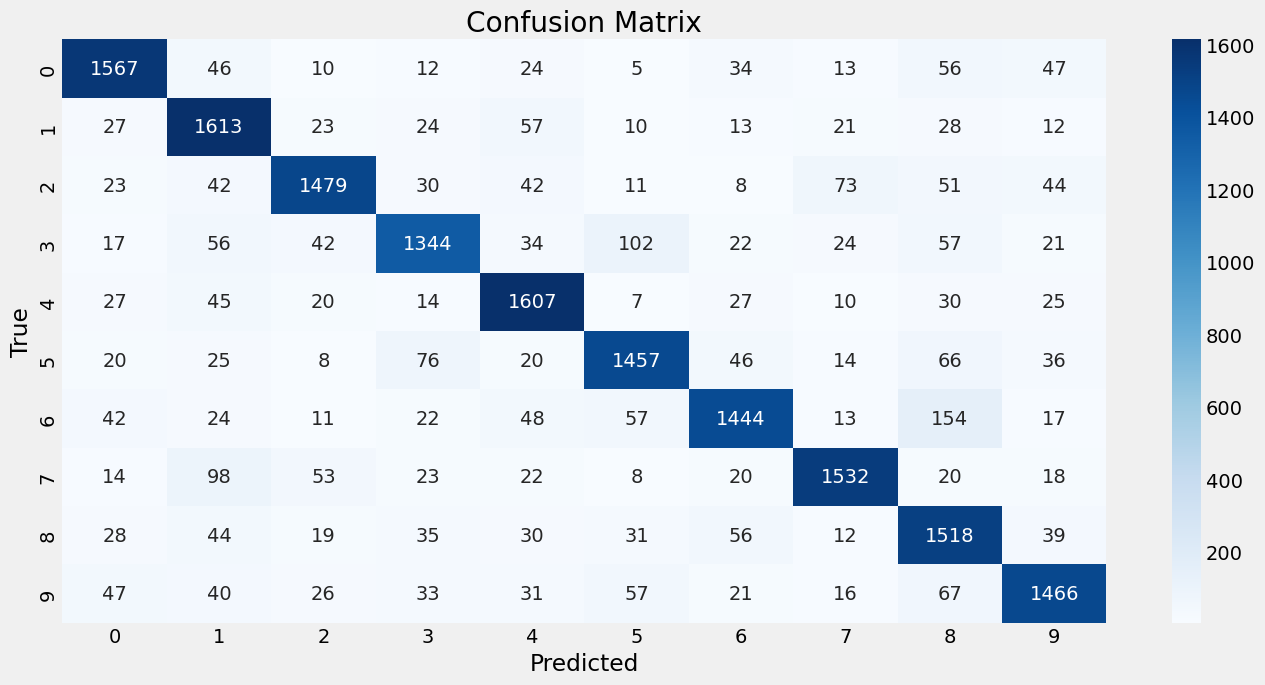

In [85]:
true_classes = np.argmax(y_test_o, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

print('Visualizing the confusion matrix')
plt.figure(figsize=(15, 7.2))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

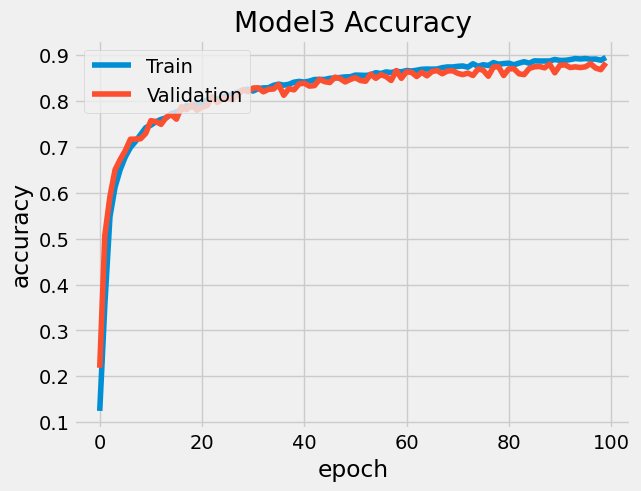

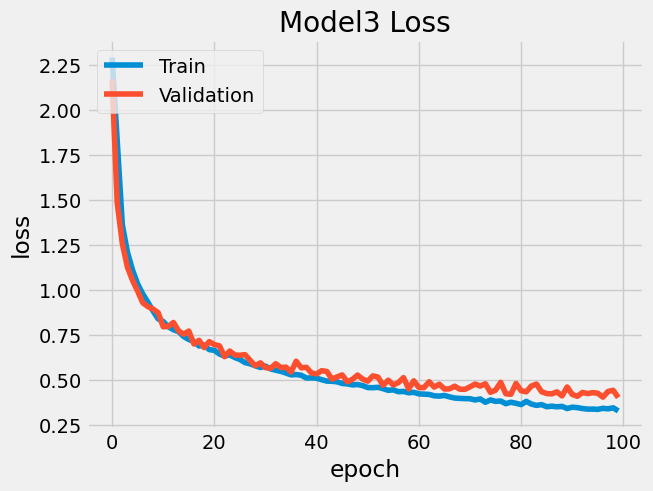

In [87]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model3 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [89]:
model3.predict(X_test)[5]

563/563 [==============================] - 1s 1ms/step


array([1.6055026e-04, 5.2281380e-06, 1.0211231e-06, 6.7398344e-07,
       2.4269555e-09, 8.2765575e-07, 1.0747666e-05, 1.8011376e-08,
       8.9617382e-04, 9.9892467e-01], dtype=float32)

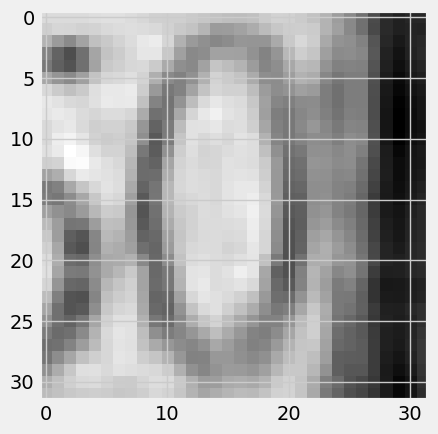

In [90]:
#Showing the image
plt.imshow(X_test[20].reshape(32, 32), cmap = 'gray')

In [92]:
model3.predict(X_test)[20]



563/563 [==============================] - 1s 1ms/step


array([9.9914181e-01, 6.2872619e-05, 2.8191223e-05, 4.6199525e-06,
       2.4291045e-05, 2.5696431e-06, 3.5903038e-04, 4.0831019e-06,
       2.2225591e-05, 3.5022834e-04], dtype=float32)

In [96]:
predicted_class = np.argmax(model3.predict(X_test)[20])

# Print the predicted class
print(f'Predicted class: {predicted_class}')

563/563 [==============================] - 1s 1ms/step
Predicted class: 0


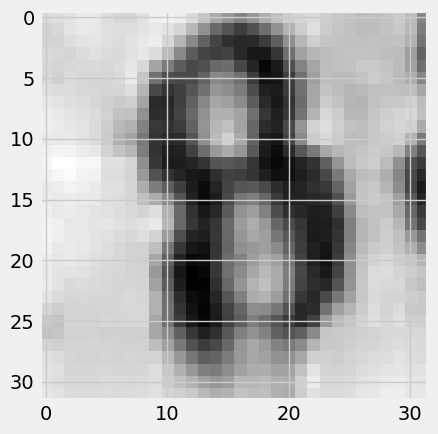

In [93]:
plt.imshow(X_test[10].reshape(32, 32), cmap = 'gray')

In [94]:
model3.predict(X_test)[10]

563/563 [==============================] - 1s 1ms/step


array([6.5280256e-05, 1.3742156e-04, 2.5355959e-05, 8.2734427e-05,
       1.8495108e-06, 8.0626422e-05, 2.5297992e-02, 8.5539109e-10,
       9.5279258e-01, 2.1516139e-02], dtype=float32)

In [95]:
# Extract the predicted class
predicted_class = np.argmax(model3.predict(X_test)[10])

# Print the predicted class
print(f'Predicted class: {predicted_class}')

563/563 [==============================] - 1s 1ms/step
Predicted class: 8


<a id='Conclusion'></a>
### Conclusion
Evaluated the accuracy using two methods i.e. baby sitting the NN and NN through API. Followed all the required steps starting with loading the datasets to performing hyperparameter optimization and running a finer search by using a finer range. Explored different options in optimizers, number of activators, learning rate and activation methods in NN through API. Found that baby sitting process achieved the best accuracy of 21% using hyper parameter optimization. It might have been further improved but that's the trade off vs time taken to run the script. NN through API method achieved best accuracy of 90% on validation set. Also printed the classification report, visualized the confusion matrix and summarized history for accuracy and loss.